In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
from IPython import display
import os
import torch
from torch import nn
import torchvision
from torch.utils import data
from torchvision import transforms

from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt

# 创建保存模型参数的目录
if not os.path.exists('./models'):
    os.makedirs('./models')

In [2]:
config = {
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)   
    'save_path': './models/model.ckpt',  # Your model will be saved here.
    'k': 5,         #交叉验证折数
    'num_epochs': 1000,
    'lr': 0.001,
    'weight_decay': 0.01,
    'batch_size': 256 
}

def same_seed(seed): 
    #A bool that, if True, causes cuDNN to only use deterministic convolution algorithms.确定性卷积算法
    torch.backends.cudnn.deterministic = True
    #A bool that, if True, causes cuDNN to benchmark multiple convolution algorithmsand select the fastest.
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    #设置CUDA的随机数生成器的种子.通过设置相同的种子，确保了在相同的种子下，使用CUDA生成的随机数也是一致的。
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
def select_feat(train_data,test_data):
    #选择训练目标列
    y_train= train_data[:,-1]

    raw_X_train, raw_X_test = train_data[:,:-1], test_data

    #选择训练列
    feat_idx = list(range(1, raw_X_train.shape[1]))
        
    return raw_X_train[:,feat_idx], y_train, raw_X_test[:,feat_idx]

### 读取文件

In [3]:
# Set seed for reproducibility
same_seed(config['seed'])

train_data, test_data = pd.read_csv('./train.csv').values, pd.read_csv('./test.csv').values

# Print out the data size.将划分的结果打印出来
print(f"""train_data size: {train_data.shape} test_data size: {test_data.shape}""")

# Select features
train_features, train_labels,test_features= select_feat(train_data, test_data)


train_features.shape, train_labels.shape,test_features.shape

train_data size: (1460, 333) test_data size: (1459, 332)


((1460, 331), (1460,), (1459, 331))

In [4]:
def try_gpu(i=0): 
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

device=try_gpu()
#将数据放入GPU
train_features = torch.tensor(train_features, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_labels, dtype=torch.float32).to(device)

test_features = torch.tensor(test_features, dtype=torch.float32).to(device)

### Model Loss

In [5]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

class Model(nn.Module):
    def __init__(self, in_features):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(in_features,1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1024,1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1024,256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256,64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64,1)       
    )
    def forward(self, x):
        x = self.layers(x)
        #(B, 1) -> (B)，将维度去除，原来是(batch_size*1)去除后变为(1)
        x = x.squeeze(1) 
        return x
    
def get_net():
    net=Model(in_features)
    return net

    #权重初始化
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

### 计算MSE，使用对数计算

In [6]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1,大于这个值的元素限制为正无穷大，确保预测结果不会超过这个上限。
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

### 训练函数

In [7]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

def train(net, train_features, train_labels, valid_features, valid_labels,
          num_epochs, learning_rate, weight_decay, batch_size,device):
    train_ls, valid_ls = [], []
    #生成训练DataLoader
    train_loader = load_array((train_features, train_labels), batch_size)
    #判断是否为交叉验证模式，生成验证DataLoader
    if valid_labels is not None:
        valid_loader=load_array((valid_features, valid_labels), batch_size,is_train=False)
    
    # 选择优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    #设置参数
    best_loss=math.inf
    count = 0
    
    for epoch in range(num_epochs):
        net.train()
        for X, y in train_loader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        #计算训练损失（得分）
        train_ls.append(log_rmse(net, train_features, train_labels))
        
        if valid_labels is not None:
            loss_record = []
            for X, y in valid_loader:
                X, y = X.to(device), y.to(device)
                with torch.no_grad():
                    loss_record.append(log_rmse(net, X,y))
            #计算验证损失（得分）
            mean_valid_loss = sum(loss_record)/len(loss_record)
            valid_ls.append(mean_valid_loss)
        
        #保存模型
        mean_train_loss = sum(train_ls)/len(train_ls)
        mean_train_loss = round(mean_train_loss, 3) 
        if mean_train_loss < best_loss:
            best_loss = mean_train_loss
            torch.save(net.state_dict(), './models/model.ckpt') 
            # print('Saving model with loss {:.3f}...'.format(best_loss))
            count = count+1  
            
    print('Saving model with loss {:.3f}...'.format(best_loss))
    print("保存模型次数：",count)
    #返回每个batch的损失
    return train_ls, valid_ls

### 画图-训练可视化函数

In [8]:
def use_svg_display():  #@save
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):  #@save
    """设置matplotlib的图表大小"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize    

#@save
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
#@save

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

## K折交叉验证

### 交叉验证时分割数据函数

In [9]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    #计算每一折的大小
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        #j* fold_size开始，(j + 1) * fold_size结束
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        #将训练集做成验证集验证
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            #在指定维度拼接向量，竖着拼，相当于将数据加到后面
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

### K折交叉验证函数

In [10]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    #做k次交叉验证
    for i in range(k):
        #data是一个元组
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net() 
        device=try_gpu()
        print('training on', device)
        net.to(device)
        net.apply(init_weights)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size,device)
        #每次都返回train_ls列表中最后一次更新的值，最后一个batch的损失
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        #将第一轮的训练loss画出
        if i == 0:
            plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        #将每一折最后一个batch的loss打印
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

### 开始训练

training on cuda:0
Saving model with loss 0.163...
保存模型次数： 362
折1，训练log rmse0.110806, 验证log rmse0.174256
training on cuda:0
Saving model with loss 0.156...
保存模型次数： 347
折2，训练log rmse0.124914, 验证log rmse0.186796
training on cuda:0
Saving model with loss 0.165...
保存模型次数： 359
折3，训练log rmse0.122960, 验证log rmse0.184786
training on cuda:0
Saving model with loss 0.155...
保存模型次数： 351
折4，训练log rmse0.114092, 验证log rmse0.166319
training on cuda:0
Saving model with loss 0.161...
保存模型次数： 346
折5，训练log rmse0.111503, 验证log rmse0.202461
5-折验证: 平均训练log rmse: 0.116855, 平均验证log rmse: 0.182923


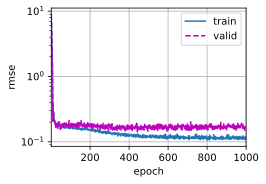

In [11]:
#训练折数
k=5
train_l, valid_l = k_fold(config['k'], train_features, train_labels, config['num_epochs'], config['lr'],
                          config['weight_decay'], config['batch_size'])
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

### K折交叉验证过后使用全部数据训练并输出预测

In [12]:
def train_and_pred(train_features, test_features, train_labels,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    device=try_gpu()
    print('training on', device)
    net.to(device)
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size,device)
    plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().cpu().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data =pd.read_csv('./test.csv')
    test_data['SalePrice'] = preds
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

training on cuda:0
Saving model with loss 0.170...
保存模型次数： 366
训练log rmse：0.121057


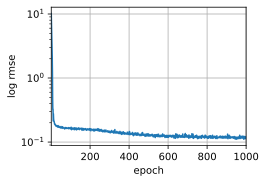

In [13]:
train_and_pred(train_features, test_features, train_labels,
               config['num_epochs'], config['lr'],config['weight_decay'], config['batch_size'])